<a href="https://colab.research.google.com/github/alouvre/ML_RS_AmazonFoodReviews/blob/main/RecommendationSystem_AmazonFoodReviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/saurav9786/recommendation-based-on-amazon-food-review

https://www.youtube.com/watch?v=KIPc0xGnRZs

In [ ]:
# Set Kaggle

# Menginstall kaggle
!pip install -q kaggle
# Membuat direktori
!mkdir ~/.kaggle
# Menyalin kaggle.json ke dir kaggle
!cp kaggle.json ~/.kaggle/
# Meminta izin untuk akses
!chmod 600 ~/.kaggle/kaggle.json

!kaggle -h

mkdir: cannot create directory ‘/root/.kaggle’: File exists
usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,models,m,files,f,config} ...

options:
  -h, --help            show this help message and exit
  -v, --version         show program's version number and exit

commands:
  {competitions,c,datasets,d,kernels,k,models,m,files,f,config}
                        Use one of:
                        competitions {list, files, download, submit, submissions, leaderboard}
                        datasets {list, files, download, create, version, init, metadata, status}
                        kernels {list, init, push, pull, output, status}
                        config {view, set, unset}
    competitions (c)    Commands related to Kaggle competitions
    datasets (d)        Commands related to Kaggle datasets
    kernels (k)         Commands related to Kaggle kernels
    files (f)           Commands related files
    config              Configuration settings


In [ ]:
import zipfile

# Mengunduh dataset
!kaggle datasets download -d 'snap/amazon-fine-food-reviews'

# Membuat direktori dataset
!mkdir dataset

# Mengekstraksi file zip
nama_file_zip = 'amazon-fine-food-reviews.zip'
nama_folder_tujuan = 'dataset'
dataset_zip = zipfile.ZipFile(nama_file_zip,'r')
dataset_zip.extractall('dataset')
dataset_zip.close()

# Memindahkan files ke direktori dataset
!mv amazon-fine-food-reviews.zip dataset

100% 241M/242M [00:09<00:00, 29.7MB/s]
100% 242M/242M [00:09<00:00, 27.4MB/s]


In [ ]:
import pandas as pd
import numpy as np

import math
import joblib
import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [ ]:
amazon_data = pd.read_csv('dataset/Reviews.csv', index_col='Id')
amazon_data1 = amazon_data

In [ ]:
amazon_data.columns

Index(['ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [ ]:
amazon_data1 = amazon_data1[['ProductId', 'UserId', 'ProfileName', 'Score', 'Time']]

In [ ]:
# Untuk pengecekan apakah column data yang tidak diperlukan sudah terhapus atau belum
amazon_data1.head()

,ProductId,UserId,ProfileName,Score,Time
Id,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,5,1303862400
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,1,1346976000
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",4,1219017600
4,B000UA0QIQ,A395BORC6FGVXV,Karl,2,1307923200
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",5,1350777600


In [ ]:
# Untuk pengecekan type data setiap columnnya
amazon_data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 568454 entries, 1 to 568454
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   ProductId    568454 non-null  object
 1   UserId       568454 non-null  object
 2   ProfileName  568438 non-null  object
 3   Score        568454 non-null  int64 
 4   Time         568454 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 26.0+ MB


In [ ]:
# Untuk dilakukannya pengecekan data statistik berdasarkan Score/Rating yang diberikan oleh customer
amazon_data1[['Score']].describe().T

,count,mean,std,min,25%,50%,75%,max
Score,568454.0,4.183199,1.310436,1.0,4.0,5.0,5.0,5.0


In [ ]:
# Untuk dilakukannya pengecekan data di setiap columnnya apakah terdapat missing values/null atau tidak
print('Jumlah missing values berdasarkan kolom-kolom :\n\n', amazon_data1.isnull().sum())

Jumlah missing values berdasarkan kolom-kolom :

 ProductId       0
UserId          0
ProfileName    16
Score           0
Time            0
dtype: int64


In [ ]:
# Hapus column ProfileName karena untuk column ini sudah terwakilkan oleh User Id
# Selain itu juga column ini terdapat missing values
amazon_data1 = amazon_data1.drop(['ProfileName'], axis = 1)

In [ ]:
rows, columns = amazon_data1.shape
print("Jumlah Baris: ", rows)
print("Jumlah Kolom: ", columns)

Jumlah Baris:  568454
Jumlah Kolom:  4


In [ ]:
print('Rating paling rendah : %d' %(amazon_data1['Score'].min()))
print('Rating paling tinggi : %d' %(amazon_data1['Score'].max()))

Rating paling rendah : 1
Rating paling tinggi : 5


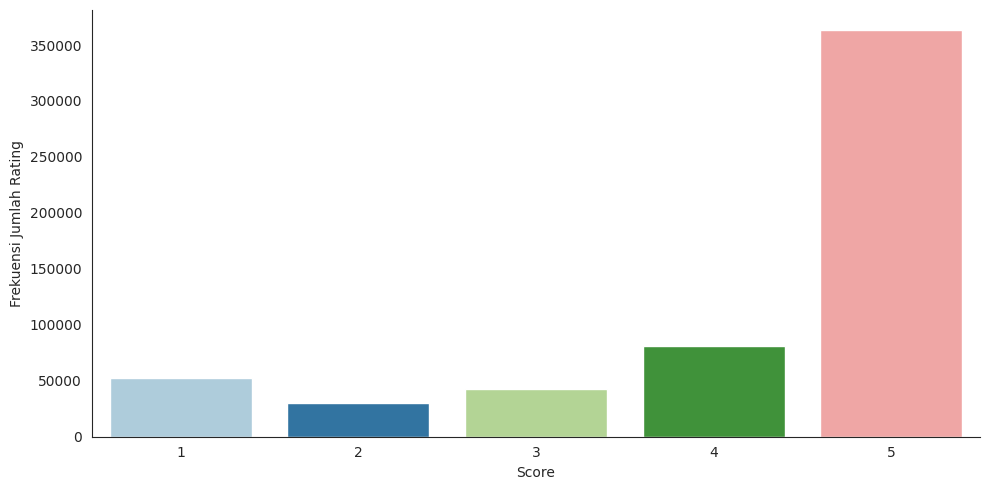

In [ ]:
# Cek distribusi data menggunakan plot berdasarkan Score/Rating
with sns.axes_style('white'):
  g = sns.catplot(x = "Score",
                  data = amazon_data1,
                  aspect = 2.0,
                  kind = 'count',
                  palette = 'Paired')
  g.set_ylabels('Frekuensi Jumlah Rating')

In [ ]:
print("Total data")
print("-"*30)
print("\nJumlah Nilai     :", amazon_data1.shape[0])
print("Jumlah Pengguna  :", len(np.unique(amazon_data1.UserId)))
print("Jumlah Produk    :", len(np.unique(amazon_data1.ProductId)))

Total data
------------------------------

Jumlah Nilai     : 568454
Jumlah Pengguna  : 256059
Jumlah Produk    : 74258


Dari keterangan data diatas menunjukkan bahwa satu barang dapat review oleh banyak pengguna, dan jika ditotal semua baris dari adataset review fine food amazon ini yang berjumlah 568454

In [ ]:
# Menganalisis Score yang diberikan User terhadap Produk
# Satu User dapat mereview beberapa produk
# Untuk hasil di bawah adalah jumlah skor setiap user terhadap beberapa produk yang direview

jumlah_ulasan_produk_per_user = amazon_data1.groupby(by='UserId')['Score'].count().sort_values(ascending=False)

jumlah_produk_yang_dinilai = amazon_data1.groupby(by='ProductId')['Score'].count().sort_values(ascending=False)

print(jumlah_produk_yang_dinilai.head(10), "\n")
print(jumlah_ulasan_produk_per_user.head(10))

ProductId
B007JFMH8M    913
B0026RQTGE    632
B002QWHJOU    632
B002QWP89S    632
B002QWP8H0    632
B003B3OOPA    623
B001EO5Q64    567
B0026KPDG8    564
B000VK8AVK    564
B006HYLW32    564
Name: Score, dtype: int64 

UserId
A3OXHLG6DIBRW8    448
A1YUL9PCJR3JTY    421
AY12DBB0U420B     389
A281NPSIMI1C2R    365
A1Z54EM24Y40LL    256
A1TMAVN4CEM8U8    204
A2MUGFV2TDQ47K    201
A3TVZM3ZIXG8YW    199
A3PJZ8TU8FDQ1K    178
AQQLWCMRNDFGI     176
Name: Score, dtype: int64


In [ ]:
print("\nJumlah pengguna yang memberikan ulasan lebih dari 50 : {}".format(sum(jumlah_ulasan_produk_per_user >= 50)), "PENGGUNA")


Jumlah pengguna yang memberikan ulasan lebih dari 50 : 267 PENGGUNA


In [ ]:
amazon_data1 = amazon_data1.drop(['Time'], axis = 1)

In [ ]:
# Buat dataframe baru dimana terdapat pengguna yang memberikan rating 50 atau lebih

# df_final = amazon_data1.groupby("ProductId").filter(lambda x:x['Score'].count() >= 50)
# df_final.head()

counts = amazon_data1['UserId'].value_counts()
df_final = amazon_data1[amazon_data1['UserId'].isin(counts[counts >= 50].index)]

In [ ]:
print("Total data")
print("-"*30)
print("\nJumlah Nilai     :", df_final.shape[0])
print("Jumlah Pengguna  :", df_final['UserId'].nunique())
print("Jumlah Produk    :", df_final['ProductId'].nunique())

Total data
------------------------------

Jumlah Nilai     : 22941
Jumlah Pengguna  : 267
Jumlah Produk    : 11313


## Splitting Data

In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163003 sha256=56ef4fefcd62ada67c28e408d83186a4fc2b8b8d47177883e9d0696cd2d686d3
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [ ]:
# Konversi DataFrame ke dataset surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_final[['UserId', 'ProductId', 'Score']], reader)

# Split data menjadi set data latih dan uji
train_set, test_set = train_test_split(data, test_size=0.3, random_state=10)

print(train_set)

In [ ]:
algo = KNNWithMeans(k = 5,
                    sim_options = {'name': 'pearson_baseline',
                                  'item_based': True})
algo.fit(train_set)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [ ]:
test_pred = algo.test(test_set)

In [ ]:
test_pred

[Prediction(uid='A1IU7S4HCK1XK0', iid='B002IEZJMA', r_ui=5.0, est=3.4507089586655235, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid='A281NPSIMI1C2R', iid='B000CQG8AS', r_ui=5.0, est=5, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid='A1P2XYD265YE21', iid='B003XDH6M6', r_ui=5.0, est=4.763502205032765, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid='A26NFIQ7KWI8Y7', iid='B00634YDEQ', r_ui=4.0, est=4.236579897870221, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A3EBHHCZO6V2A4', iid='B001EO5RYK', r_ui=5.0, est=4.236579897870221, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A106ZCP7RSXMRU', iid='B000KFU6RW', r_ui=4.0, est=4.794117647058823, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='AMRMK86X3PKXD', iid='B000FBOA5A', r_ui=5.0, est=4.780487804878049, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(

In [ ]:
# Untuk pengecekan prediksi menggunakan pemodelan algoritma KNNWithMeans
recom_knn = algo.predict(uid='A3M8R4JD1SIS76', iid='B0018SMUVA')
recom_knn

Prediction(uid='A3M8R4JD1SIS76', iid='B0018SMUVA', r_ui=None, est=4.236579897870221, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [ ]:
# RMSE
print('Item-based Model : Test Set')
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.0042


1.004198694513623

In [ ]:
# Model Base Collaborative Filtering

df_final1 = df_final.head(10000)
ratings_matrix = df_final1.pivot_table(values = 'Score',
                                       index = 'UserId',
                                       columns = 'ProductId')
ratings_matrix.fillna(0, inplace= True)

ratings_matrix.head()

ProductId,7310172001,7310172101,B00004RYGX,B00004S1C6,B00006IDK9,B000084E66,B000084EK4,B000084EK5,B000084EK6,B000084EK7,...,B00954NYVY,B0096EZHM2,B0096UUUAU,B009B87TKG,B009GHI6I6,B009KAQW12,B009KAQZ9G,B009KOHGEK,B009KP6HBM,B009LT26BC
UserId,,,,,,,,,,,,,,,,,,,,,
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A106ZCP7RSXMRU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1080SE9X3ECK0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10G136JEISLVR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A11ED8O95W2103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print('Shape of final_ratings_matrix: ', ratings_matrix.shape)

Shape of final_ratings_matrix:  (267, 4743)


In [ ]:
given_num_of_ratings = np.count_nonzero(ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

given_num_of_ratings =  8974


In [ ]:
possible_num_of_ratings = ratings_matrix.shape[0] * ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

possible_num_of_ratings =  1266381


In [ ]:
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

density: 0.71%


In [ ]:
X = ratings_matrix.T
X.head()

UserId,A100WO06OQR8BQ,A106ZCP7RSXMRU,A1080SE9X3ECK0,A10G136JEISLVR,A11ED8O95W2103,A11OTLEDSW8ZXD,A12ENBT314RFXR,A132ETQPMHQ585,A13GZCHAMKWYBT,A13HRSMJ5TOWEZ,...,ATJN4KEHJBOC8,AVFA1JB08RG8G,AWKZAUC0D8DYL,AXO4PQU0XG3TG,AY12DBB0U420B,AY1EF0GOH80EK,AYB4ELCS5AM8P,AYGJ96W5KQMUJ,AYOMAHLWRQHUG,AZV26LP92E6WU
ProductId,,,,,,,,,,,,,,,,,,,,,
7310172001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7310172101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00004RYGX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
B00004S1C6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00006IDK9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X.shape

(4743, 267)

In [ ]:
X1 = X
# Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix

array([[ 8.05272224e-02,  2.36801032e-02, -2.78444909e-02, ...,
         1.34673354e-02, -3.03604199e-02,  4.34959753e-02],
       [ 8.05272224e-02,  2.36801032e-02, -2.78444909e-02, ...,
         1.34673354e-02, -3.03604199e-02,  4.34959753e-02],
       [ 3.66152785e-01,  1.11174353e-01,  3.04500374e-01, ...,
         4.82764855e-02, -1.38705959e-02, -4.30500361e-02],
       ...,
       [ 3.81202092e-02,  1.72902715e-02,  1.63221790e-01, ...,
         1.31177181e-01,  7.32456218e-02,  1.25801695e-01],
       [ 3.14768199e-01,  3.57388188e-04, -6.99982235e-02, ...,
         2.02978787e-01, -1.47427451e-01,  1.27317347e-01],
       [ 4.73795905e-01, -1.89201307e-01, -2.62976272e-01, ...,
        -4.72989374e-02,  7.11531997e-02, -1.91674369e-01]])

In [ ]:
# Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(4743, 4743)

In [ ]:
X.index[30]

'B0000CDBPV'

In [ ]:
# Dilakukan pengecekan Product ID
i = "B0000CDBPV"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

30

In [ ]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(4743,)

In [ ]:
# Merekomendasikan suatu barang apabila customer membeli sebuah barang sesuai index diatas

Recommend = list(X.index[correlation_product_ID > 0.30])

Recommend.remove(i)

Recommend[0:24]

['7310172001',
 '7310172101',
 'B00004S1C6',
 'B000084E66',
 'B000084ETV',
 'B00008JOL0',
 'B00008O36H',
 'B00008WUA9',
 'B0000A0BS8',
 'B0000CFN0Y',
 'B0000CNU1X',
 'B0000CNU2Q',
 'B0000D9N0Q',
 'B0000D9N59',
 'B0000DA0XJ',
 'B0000DG55U',
 'B0000DHWZH',
 'B0000DID5R',
 'B0000DID6A',
 'B0000DIYKD',
 'B0000DIYVM',
 'B0000DJDJZ',
 'B0000E65W9',
 'B0000GIZTC']

# Splitting Data